# Processing III: motion tracking and balance

In the previous notebook, we have ran pose estimation on the trial videos (OpenPose), and triangulated the coordinates to get 3D coordinates for each trial (pose2sim). Furthermore, we have performed inverse kinematics and dynamics to extract joint angles and moments.

In this script, we will clean the data, and extract further information (such as speed, acceleration, etc.). 

In [ ]:
#| code-fold: true
#| code-summary: Code to load packages and prepare the environment


# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy


curfolder = os.getcwd()
print(curfolder)

# files to work with
MTfolder = 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\' ## FLAGGED CHANGE
BBfolder = curfolder + '\\..\\01_XDF_processing\\data\\Data_processed\\Data_trials\\'

# folders to save the processed data
MTfolder_processed = curfolder + '\\TS_motiontracking\\'

e:\FLESH_ContinuousBodilyEffort\03_TS_processing


## Motion tracking - kinematics

In [ ]:
#| code-fold: true
#| code-summary: Code to prepare files to process

MTtotrack = glob.glob(MTfolder + '*/P*/*', recursive=True)

# get rid of all the folders that are not the ones we want to track, like .sto files
MTtotrack = [x for x in MTtotrack if 'sto' not in x]
MTtotrack = [x for x in MTtotrack if 'txt' not in x]
MTtotrack = [x for x in MTtotrack if 'xml' not in x]
MTtotrack = [x for x in MTtotrack if 'opensim' not in x]
MTtotrack = [x for x in MTtotrack if 'Results' not in x]
MTtotrack = [x for x in MTtotrack if 'toml' not in x]

print(MTtotrack)

MTfiles_all = []

for folder in MTtotrack:
    print('working on:' + folder)
    # last element is trialid
    trialid = folder.split('\\')[-1]
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '\\**\\*.csv', recursive=True)
    # keep only the ones that have butterworth in the name
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]
    # append to list with trialid
    MTfiles_all.append([trialid, butterfile])

['C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_0_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_18_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_19_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_1_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_20_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_21_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_22_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_23_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\Session_0_1\\P0\\0_1_24_p0', 'C:\\Users\\kadava\\Documents\\Github\\FLESH_3Dtracking_new\\projectdata\\

The data can still be noisy, as the OpenPose in-built filter is not particularly strong. We don't want to smooth all the keypoints with the same strength, as some keypoints are more prone to noise than others. We can therefore use the function `check_smooth_strength` to check the effect of different smoothing strengths on the data. 

In [ ]:
#| code-fold: true
#| code-summary: Code with function to check smoothing strength

# function to check different smoothing windows and orders
def check_smooth_strength(df, keycols, windows, orders, keytoplot):

    # prepare new df
    df_smooth = pd.DataFrame()

    for col in keycols:
        for win in windows:
            for ord in orders:
                df_smooth[col + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(df[col], win, ord)

    # make R_Hand_x from df_sample a list
    keycol_x = df[keycols[0]].tolist()
    keycol_y = df[keycols[1]].tolist()
    keycol_z = df[keycols[2]].tolist()

    # load these values into df_smooth as a new column
    df_smooth[keycols[0]] = keycol_x
    df_smooth[keycols[1]] = keycol_y
    df_smooth[keycols[2]] = keycol_z

    # plot keytoplot in all strngths
    colstoplot = [x for x in df_smooth.columns if keytoplot in x]
    plt.figure()
    for col in colstoplot:
        plt.plot(df_smooth[col], label=col)
    plt.legend()
    plt.show()



C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_43_p0\pose-3d\0_1_43_p0_0-253_filt_butterworth.trc.csv


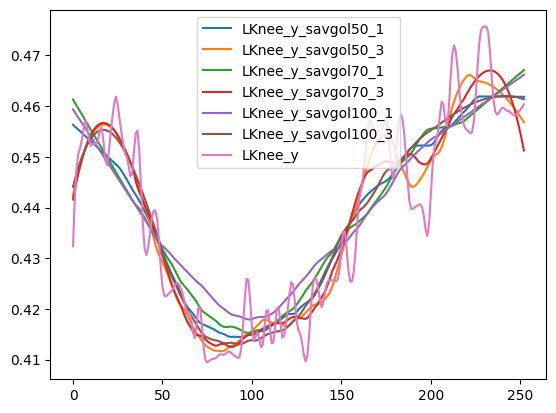

In [ ]:
#| code-fold: true
#| code-summary: Code to plot

print(MTfiles_all[20][1])
sample = pd.read_csv(MTfiles_all[20][1], sep=',')

windows = [50,70,100] # list possible window
orders = [1,3] # list possible orders

# col of interest
samplecol = ['LKnee_x', 'LKnee_y', 'LKnee_z']

check_smooth_strength(sample, samplecol, windows, orders, 'LKnee_y')

We used OpenPose (XX) for pose estimation, and pose2sim (XX) for triangulation.

Here we clean the data, and smooth coordinates and derivatives with a Savitzky-Golay filter. We vary the strength (i.e., window and order) according to which keypoint we are smoothing (e.g., lower versus upper body)

To get aggregated kinematic measures for each body group (i.e., head, upperbody, arms, lowerbody), we compute euclidian sum on each derivative belonging to the group.

In [ ]:
#| code-fold: true
#| code-summary: Code with functions for processing kinematic data

# function to get euclidian sum of associated keypoints

def aggregate_keypoints(df, measurement, finalcolname, use):

    if use == 'kinematics':
        # group keypoints that belong together
        lowerbodycols = ['RHip', 'LHip']
        legcols = ['RKnee', 'RAnkle', 'LAnkle', 'LKnee', 'RHeel', 'LHeel']
        headcols = ['Head', 'Neck', 'Nose']
        armcols = ['RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'RIndex', 'LIndex']

        groups = [lowerbodycols, legcols, headcols, armcols]

    elif use == 'angles':
        pelviscols = ['pelvis']
        spinecols = ['L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']
        lowerbodycols = ['pelvis', 'hip']
        legcols = ['knee', 'ankle', 'subtalar']
        headcols = ['neck']
        armcols = ['arm', 'elbow', 'wrist', 'pro_sup']

        groups = [lowerbodycols, legcols, headcols, armcols, pelviscols, spinecols]

    # make subdf only with speed
    subdf = df[[x for x in df.columns if measurement in x]]

    # loop through each joint group
    for group in groups:
        # get cols
        cols = [x for x in subdf.columns if any(y in x for y in group)]
        subdf_temp = subdf[cols]

        for index, row in subdf_temp.iterrows():
            # get all values of that row
            values = row.values
            # calculate euclidian sum
            euclidian_sum = np.sqrt(np.sum(np.square(values))) ## FLAGGED: possibly normalize
            # get a name for new col
            if group == lowerbodycols:
                colname = 'lowerbody'
            elif group == legcols:
                colname = 'leg'
            elif group == headcols:
                colname = 'head'
            elif group == armcols:
                colname = 'arm'
            elif group == pelviscols:
                colname = 'pelvis'
            elif group == spinecols:
                colname = 'spine'
                

            df.loc[index, colname + finalcolname] = euclidian_sum

    return df


# get kinematic derivatives
def get_derivatives(df, sr, upperbodycols, lowerbodycols, use):

    mtcols = df.columns
    if use == 'kinematics':
        # get rid of cols that are not x, y or z
        mtcols = [x for x in mtcols if '_x' in x or '_y' in x or '_z' in x]
    

        # prepare cols for speed
        cols = [x.split('_')[0] for x in mtcols]
        colsforspeed = list(set(cols))

        # for each unique colname (cols), calculate speed 
        for col in colsforspeed:
            # get x and y columns
            x = df[col + '_x']
            y = df[col + '_y']
            z = df[col + '_z'] # note that y and z are flipped
            # calculate speed
            speed = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2),0,0)
            # multiply the values by sr, because now we have values in m/(s/sr)
            speed = speed*sr

            # smooth
            if any(x in col for x in upperbodycols):
                speed = scipy.signal.savgol_filter(speed, 15, 1)
            elif any(x in col for x in lowerbodycols):
                speed = scipy.signal.savgol_filter(speed, 20, 1)
            else:
                speed = scipy.signal.savgol_filter(speed, 15, 1)

            # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
            if 'Wrist' in col:
                verticvel = np.insert(np.diff(z), 0, 0)
                verticvel = verticvel*sr
                verticvel = scipy.signal.savgol_filter(verticvel, 15, 1)

            # derive acceleration	
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 15, 1)

            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 15, 1)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    elif use == 'angles':
        # get rid of cols that are not angles (so skip time)
        mtcols = mtcols[1:]

        # derive speed
        for col in mtcols:
            speed = np.insert(np.diff(df[col]), 0, 0)
            speed = speed*sr
            speed = scipy.signal.savgol_filter(speed, 15, 1)

            # derive acceleration
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 15, 1)
            
            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 15, 1)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    return df


In [ ]:
#| code-fold: false
#| code-summary: Code to process kinematics

# upper body cols
upperbodycols = ['Head', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'Nose', 'RIndex', 'LIndex']
# lower body cols
lowerbodycols = ['RHip', 'RKnee', 'RAnkle', 'RHeel' 'LHip', 'LKnee', 'LAnkle', 'LHeel']

for folder in MTtotrack:
    print('working on:' + folder)
    # last element is trialid
    trialid = folder.split('\\')[-1]
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '/**/*.csv', recursive=True)
    # keep only the ones that have butterworth in the name
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]

    # load it
    mt = pd.read_csv(butterfile)

    # the mt is missing 0 ms timepoint, so we need to create a row that copies the first row of mt and time = 0
    padrow = mt.iloc[0].copy()
    padrow['Time'] = 0

    # concatenate it to the beginning of mt 
    mt = pd.concat([pd.DataFrame(padrow).T, mt], ignore_index=True)

    # keep only cols of interest
    colstokeep = ["Time", "RHip", "RKnee", "RAnkle", "RHeel", "LHip", "LKnee", "LAnkle", "LHeel", "Neck", "Head", "Nose", "RShoulder", "RElbow", "RWrist", "RIndex", "LShoulder", "LElbow", "LWrist",
    "LIndex",
]
    mt = mt[[col for col in mt.columns if any(x in col for x in colstokeep)]]

        # if col has _y in it, replace it by _temp
    mt.columns = [x.replace('_y', '_temp') for x in mt.columns]
    # replace _z by _y
    mt.columns = [x.replace('_z', '_y') for x in mt.columns]
    # replace _temp by _z
    mt.columns = [x.replace('_temp', '_z') for x in mt.columns]

    # smooth all columns except time with savgol
    mtcols = mt.columns
    colstosmooth = mtcols[:-1]

    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        # if the col + x/y/z is in upperbodycols, smooth with 15,1
        if any(x in col for x in upperbodycols):
            mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)
        # as the lowerbody keypoints are not moving that much, they are much more prone to noise (e.g., from the measurement error of OpenPose, therefore we will smooth them with a little higher window)
        elif any(x in col for x in lowerbodycols):
            mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 1)
        else:
            mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 15, 1)

        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100

    # add back time column
    mt_smooth['Time'] = mt['Time']

    # get sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    # get kinematic derivatives
    mt_smooth = get_derivatives(mt_smooth, sr, upperbodycols, lowerbodycols, 'kinematics')

    # getting aggreagated sums for groups of cols
    mt_smooth = aggregate_keypoints(mt_smooth, 'speed', '_speedKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'acc', '_accKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'jerk', '_jerkKin_sum', 'kinematics')

    # add trialid
    mt_smooth['TrialID'] = trialid
    # convert time to ms
    mt_smooth['Time'] = mt_smooth['Time']*1000
    # write to csv
    mt_smooth.to_csv(MTfolder_processed + '/mt_' + trialid + '.csv', index=False)


working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_0_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_18_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_19_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_1_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_20_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_21_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_22_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_23_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\0_1_24_p0
working on:C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session

Let's check one file to see how the data looks like by plotting RWrist and its kinematics, and also the euclidian sum for the whole arm along with it

['e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_0_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_18_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_19_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_1_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_20_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_21_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_22_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_23_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_24_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_25_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_26_p0.csv', 

C:\Users\kadava\AppData\Local\Temp\ipykernel_22764\1328422451.py:49: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3, wspace=0.3)


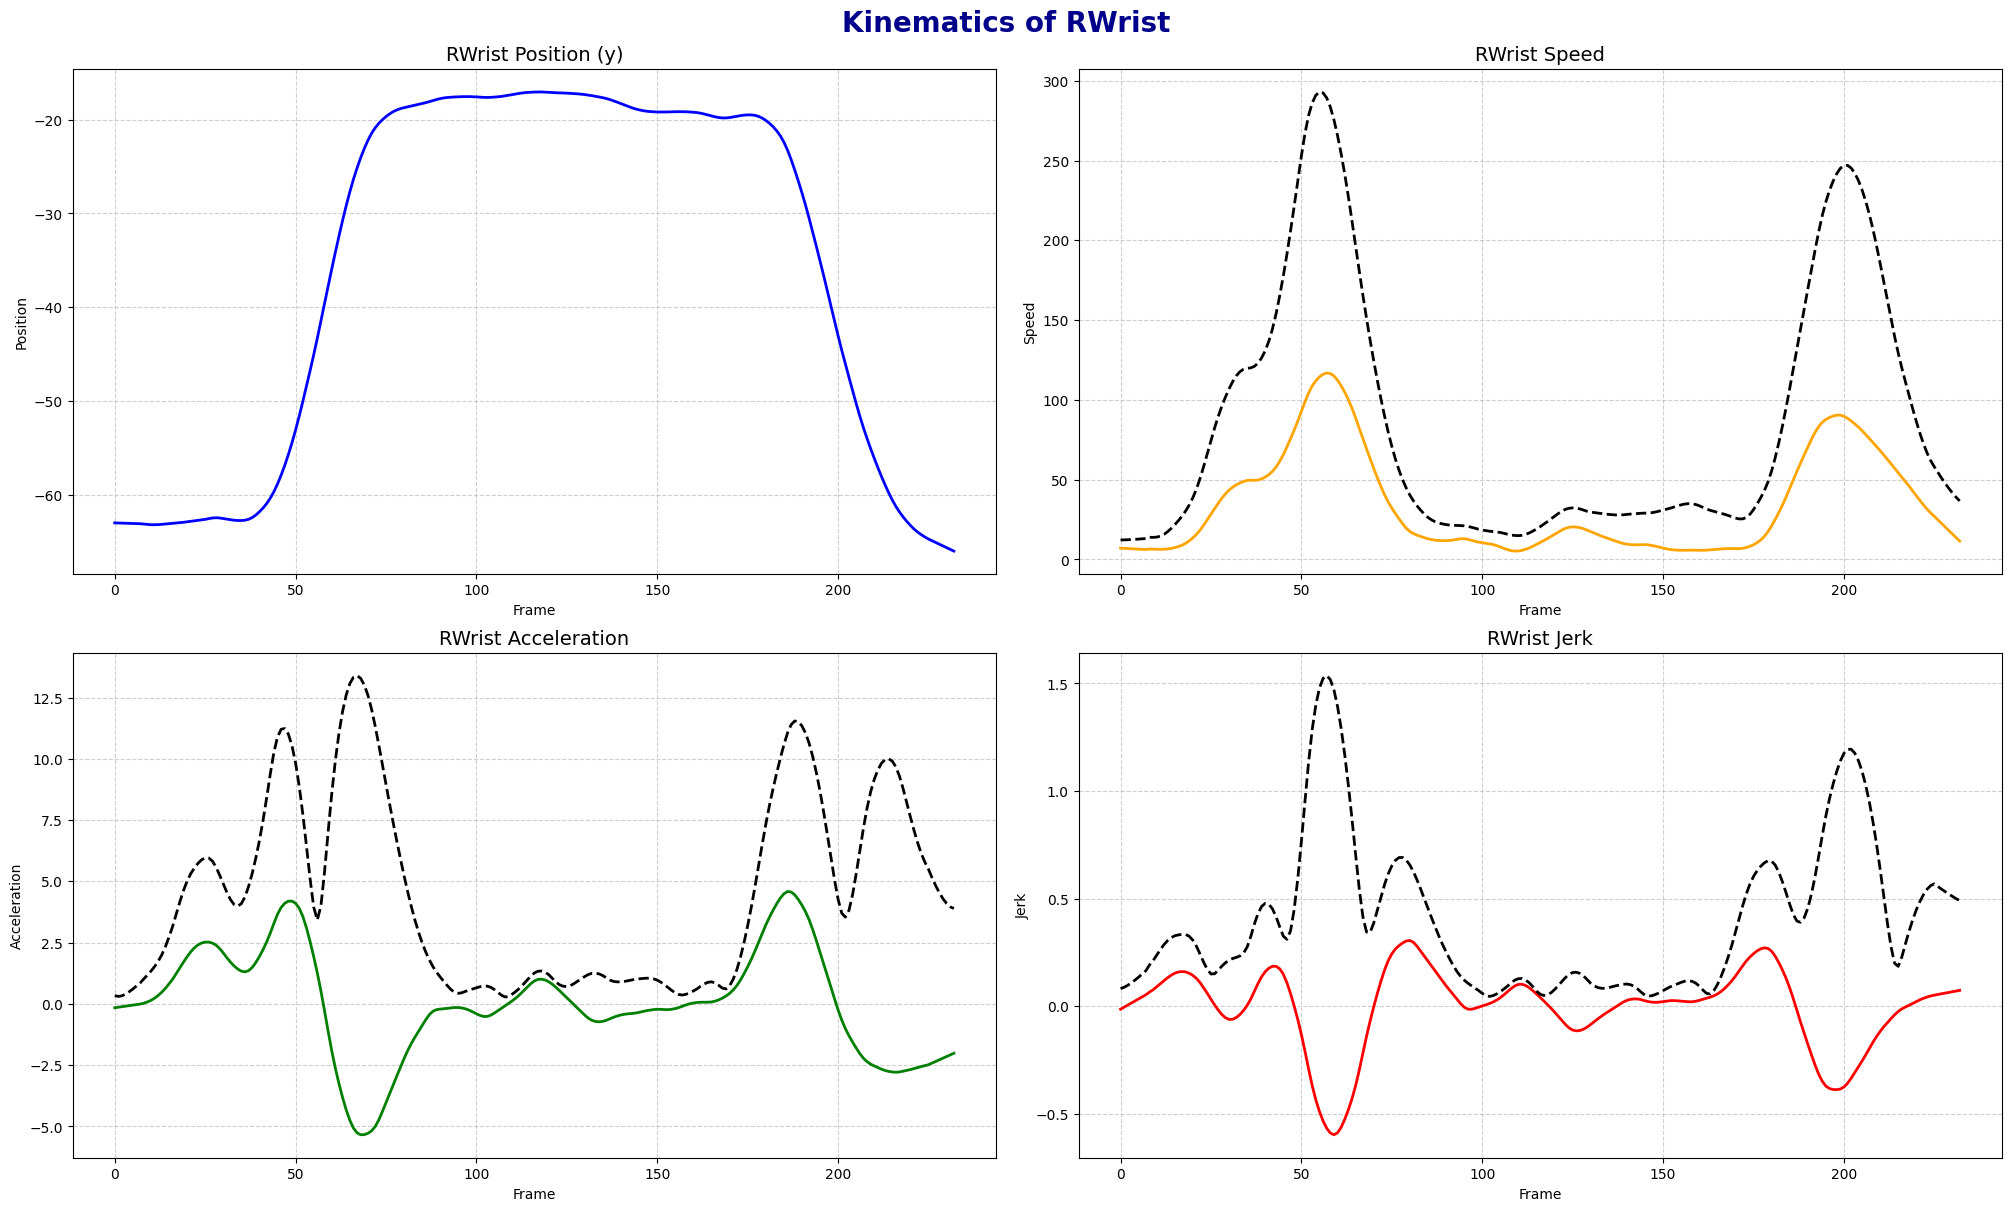

In [ ]:
#| code-fold: true
#| code-summary: Show code for this plot

# Load one file to check
MTfiles = glob.glob(MTfolder_processed + '/*.csv')
print(MTfiles)
sample = pd.read_csv(MTfiles[4])

# Define colors and styles
colors = ['blue', 'orange', 'green', 'red']
titles = ['RWrist_y', 'RWrist_speed', 'RWrist_acc', 'RWrist_jerk']

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
fig.suptitle('Kinematics of RWrist', fontsize=20, fontweight='bold', color='darkblue')

# Plot RWrist_y
axs[0, 0].plot(sample['RWrist_y'], color=colors[0], linewidth=2)
axs[0, 0].set_title('RWrist Position (y)', fontsize=14)
axs[0, 0].set_xlabel('Frame')
axs[0, 0].set_ylabel('Position')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_speed
axs[0, 1].plot(sample['RWrist_speed'], color=colors[1], linewidth=2)
# add arm sum
axs[0, 1].plot(sample['arm_speedKin_sum'], color='black', linewidth=2, linestyle='--')
axs[0, 1].set_title('RWrist Speed', fontsize=14)
axs[0, 1].set_xlabel('Frame')
axs[0, 1].set_ylabel('Speed')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_acc
axs[1, 0].plot(sample['RWrist_acc'], color=colors[2], linewidth=2)
# add arm sum
axs[1, 0].plot(sample['arm_accKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 0].set_title('RWrist Acceleration', fontsize=14)
axs[1, 0].set_xlabel('Frame')
axs[1, 0].set_ylabel('Acceleration')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_jerk
axs[1, 1].plot(sample['RWrist_jerk'], color=colors[3], linewidth=2)
# add arm sum
axs[1, 1].plot(sample['arm_jerkKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 1].set_title('RWrist Jerk', fontsize=14)
axs[1, 1].set_xlabel('Frame')
axs[1, 1].set_ylabel('Jerk')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()


## Motion tracking - inverse kinematics

Using OpenSim (XX), we have extracted joint angles in the previous notebook. Now again, we clean the data and extract further information before saving it into csv file per trial

In [ ]:
#| code-fold: true
#| code-summary: Code to process joint angles

# get all mot files in the folder
mot_files = glob.glob(MTfolder + '*/P*/*/*.mot', recursive=True)
keypoints = ['wrist', 'pro_sup', 'elbow', 'arm', 'neck', 'subtalar', 'ankle', 'knee', 'hip', 'pelvis', 'L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']

for mot in mot_files:
    print('working on ' + mot)
    # get trialid
    trialid = mot.split('\\')[-1].split('.')[0]

    # get rid of the first element before _
    trialid = '_'.join(trialid.split('_')[1:])

    # load it
    mot_df = pd.read_csv(mot, sep='\t', skiprows=10)
    
    # pad 0 ms row
    padrow = mot_df.iloc[0].copy()
    padrow['time'] = 0

    # concatenate it to the beginning of mot_df
    mot_df = pd.concat([pd.DataFrame(padrow).T, mot_df], ignore_index=True)
    
    # get the sr
    sr = 1/np.mean(np.diff(mot_df['time']))

    # smooth all columns except the firts time (time) and last (trialid)
    colstosmooth = [x for x in mot_df.columns if 'time' not in x]

    # smooth
    for col in colstosmooth:
        mot_df[col] = scipy.signal.savgol_filter(mot_df[col], 15, 3)
        # convert to radians
        mot_df[col] = np.deg2rad(mot_df[col])

    # keep only columns you might use
    coi = [x for x in mot_df.columns if any(y in x for y in keypoints) or 'time' in x or 'TrialID' in x]
    mot_df2 = mot_df[coi]

    # get derivatives
    mot_df2 = get_derivatives(mot_df2, sr, [], [], 'angles')

    # aggregate data
    mot_df2 = aggregate_keypoints(mot_df2, 'speed', '_angSpeed_sum', 'angles')
    mot_df2 = aggregate_keypoints(mot_df2, 'acc', '_angAcc_sum', 'angles')
    mot_df2 = aggregate_keypoints(mot_df2, 'jerk', '_angJerk_sum', 'angles')

    # add time and trialid
    mot_df2['time'] = mot_df['time']
    # convert time to ms
    mot_df2['time'] = mot_df2['time']*1000
    mot_df2['TrialID'] = trialid

    # write to csv
    mot_df2.to_csv(MTfolder_processed + '/ik_' + trialid + '.csv', index=False)
    
    
mot_df2.head(15)


working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_0_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_18_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_19_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_1_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_20_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_21_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseKinematics\0_0_1_22_p0.mot
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projec

,time,pelvis_tilt,pelvis_list,pelvis_rotation,pelvis_tx,pelvis_ty,pelvis_tz,hip_flexion_r,hip_adduction_r,hip_rotation_r,...,arm_angAcc_sum,pelvis_angAcc_sum,spine_angAcc_sum,lowerbody_angJerk_sum,leg_angJerk_sum,head_angJerk_sum,arm_angJerk_sum,pelvis_angJerk_sum,spine_angJerk_sum,TrialID
0,0.00000,0.567181,1.681423,-1.890792,0.007019,0.005672,-0.009809,0.137578,0.091109,-0.290476,...,0.140587,0.222282,0.038946,0.009475,0.009765,0.004227,0.014213,0.004382,0.002261,0_2_99_p1
1,16.66667,0.521684,1.673445,-1.873351,0.006988,0.005628,-0.009812,0.130078,0.093247,-0.232976,...,0.130404,0.216674,0.036174,0.009750,0.008861,0.004285,0.013708,0.004324,0.002374,0_2_99_p1
2,33.33333,0.480347,1.667709,-1.851930,0.006967,0.005598,-0.009815,0.125613,0.093829,-0.190384,...,0.121226,0.211132,0.033428,0.010620,0.008024,0.004355,0.013732,0.005363,0.002493,0_2_99_p1
3,50.00000,0.442721,1.663876,-1.827272,0.006952,0.005581,-0.009816,0.123663,0.093097,-0.160670,...,0.113297,0.205662,0.030714,0.011955,0.007277,0.004437,0.014284,0.007029,0.002619,0_2_99_p1
4,66.66667,0.408358,1.661605,-1.800118,0.006945,0.005573,-0.009817,0.123709,0.091296,-0.141805,...,0.106895,0.200271,0.028042,0.013619,0.006651,0.004528,0.015305,0.008979,0.002750,0_2_99_p1
5,83.33333,0.376809,1.660556,-1.771213,0.006942,0.005573,-0.009817,0.125231,0.088668,-0.131759,...,0.102309,0.194964,0.025424,0.015507,0.006183,0.004630,0.016711,0.011064,0.002885,0_2_99_p1
6,100.00000,0.347627,1.660392,-1.741297,0.006942,0.005578,-0.009818,0.127709,0.085456,-0.128502,...,0.099788,0.189750,0.022880,0.017547,0.005910,0.004740,0.018413,0.013220,0.003025,0_2_99_p1
7,116.66667,0.320362,1.660771,-1.711114,0.006946,0.005586,-0.009819,0.130624,0.081904,-0.130005,...,0.099489,0.184635,0.020438,0.019691,0.005860,0.004859,0.020337,0.015418,0.003168,0_2_99_p1
8,133.33333,0.285751,1.660312,-1.675904,0.006945,0.005588,-0.009822,0.131855,0.078215,-0.128696,...,0.108913,0.163497,0.017677,0.021332,0.005981,0.005117,0.021447,0.017216,0.003255,0_2_99_p1
9,150.00000,0.250201,1.660207,-1.637402,0.006947,0.005591,-0.009827,0.133174,0.074125,-0.132859,...,0.117510,0.128122,0.013188,0.024059,0.005513,0.004738,0.021314,0.021137,0.003041,0_2_99_p1


## Motion tracking - inverse dynamics

In [ ]:
#| code-fold: true
#| code-summary: Code to process joint moments

# in MTfolders, find all sto files
sto_files = glob.glob(MTfolder + '*/P*/*/*.sto', recursive=True)
sto_files = [x for x in sto_files if 'ID' in x]

for sto in sto_files:
    print('working on ' + sto)

    # load it
    id_df = pd.read_csv(sto, sep='\t', skiprows=6)

    # from the filename, get the trialid
    trialid = sto.split('\\')[-1].split('.')[0]
    trialid = '_'.join(trialid.split('_')[:-1])
    trialid = '_'.join(trialid.split('_')[1:])

    # pad 0 ms row
    padrow = id_df.iloc[0].copy()
    padrow['time'] = 0

    # concatenate it to the beginning of id_df
    id_df = pd.concat([pd.DataFrame(padrow).T, id_df], ignore_index=True)

    # smooth all columns except the firts time (time) and last (trialid)
    colstosmooth = [x for x in id_df.columns if 'time' not in x]
    colstosmooth = [x for x in colstosmooth if 'TrialID' not in x]

    # smooth
    for col in colstosmooth:
        id_df[col] = scipy.signal.savgol_filter(id_df[col], 15, 3)

    # make subdf only with moments
    subdf = id_df[[x for x in id_df.columns if 'moment' in x]]

    # get aggregated euclidian sum for each joint group
    id_df = aggregate_keypoints(id_df, 'moment', '_moment_sum', 'angles')

    # for each moment col, we will also calculate the change 
    torquestodiff = [x for x in id_df.columns if 'moment' in x]

    for col in torquestodiff:
        torquechange = np.insert(np.diff(id_df[col]), 0, 0)
        id_df[col + '_change'] = np.abs(torquechange)
        id_df[col + '_change'] = scipy.signal.savgol_filter(id_df[col + '_change'], 20, 4)
        # new data
        new_data = pd.DataFrame({col + '_change': torquechange})
        id_df = pd.concat([id_df, new_data], axis=1)
    
    # convert time to ms
    id_df['time'] = id_df['time']*1000
        # add trialid
    id_df['TrialID'] = trialid

    # write to csv
    id_df.to_csv(MTfolder_processed + '/id_' + trialid + '.csv', index=False)


id_df.head(15)

working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_0_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_18_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_19_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_1_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_20_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_21_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new\projectdata\Session_0_1\P0\ResultsInverseDynamics\0_0_1_22_p0_ID.sto
working on C:\Users\kadava\Documents\Github\FLESH_3Dtracking_new

,time,pelvis_tilt_moment,pelvis_list_moment,pelvis_rotation_moment,pelvis_tx_force,pelvis_ty_force,pelvis_tz_force,hip_flexion_r_moment,hip_adduction_r_moment,hip_rotation_r_moment,...,leg_moment_sum_change,head_moment_sum_change,head_moment_sum_change,arm_moment_sum_change,arm_moment_sum_change,pelvis_moment_sum_change,pelvis_moment_sum_change,spine_moment_sum_change,spine_moment_sum_change,TrialID
0,0.00000,-6.358641,26.888319,-5.116483,5.229703,605.049870,-2.187898,-35.865298,7.514848,0.421960,...,0.000000,1.905884,0.000000,0.096475,0.000000,1.602287,0.000000,0.127849,0.000000,0_2_99_p1
1,16.66544,-4.430505,32.142168,-3.230480,-1.385355,611.099887,1.097655,-37.432245,6.293536,0.232217,...,0.445354,1.759635,-4.002635,0.105042,-0.185321,2.635546,4.506821,0.498313,-0.688822,0_2_99_p1
2,33.33210,-3.038670,36.350710,-1.863908,-5.571314,614.880113,2.667686,-38.899058,5.558248,0.069404,...,0.442579,1.642890,-2.809160,0.108187,-0.165899,3.066796,3.918576,0.708872,-0.732386,0_2_99_p1
3,49.99876,-2.117649,39.616848,-0.955239,-7.669828,616.769851,2.893383,-40.242962,5.235823,-0.067750,...,0.425877,1.548160,-1.757088,0.108002,-0.144862,3.056519,3.159820,0.795680,-0.755138,0_2_99_p1
4,66.66542,-1.601958,42.043489,-0.442942,-8.022550,617.148401,2.145934,-41.441183,5.253102,-0.180518,...,0.395230,1.468907,-0.847083,0.106242,-0.121449,2.746178,2.391425,0.791093,-0.750043,0_2_99_p1
5,83.33208,-1.426109,43.733538,-0.265487,-6.971134,616.395067,0.796528,-42.470944,5.536926,-0.270172,...,0.350762,1.399546,-0.078961,0.104332,-0.094963,2.258215,1.681260,0.723669,-0.713059,0_2_99_p1
6,99.99874,-1.524618,44.789898,-0.361343,-4.857236,614.889149,-0.783648,-43.309471,6.014133,-0.337984,...,0.292710,1.335444,0.548471,0.103362,-0.064774,1.696050,1.059707,0.618168,-0.642610,0_2_99_p1
7,116.66540,-1.831998,45.315476,-0.668981,-2.022508,613.009949,-2.223405,-43.933989,6.611566,-0.385226,...,0.221415,1.272920,1.036240,0.104089,-0.030311,1.144083,0.540130,0.495553,-0.539043,0_2_99_p1
8,133.33206,-2.108841,45.725349,-0.978905,0.495951,612.069437,-2.069439,-44.300411,7.068572,-0.421291,...,0.121959,1.209247,1.106998,0.106938,0.020931,0.667692,0.426992,0.372988,-0.337148,0_2_99_p1
9,149.99872,-2.636161,45.189822,-1.544430,3.397165,611.130651,-1.056102,-44.173042,7.591640,-0.427296,...,-0.059919,1.142647,1.682282,0.111999,0.087211,0.313236,-0.491432,0.263839,-0.032094,0_2_99_p1


Now we can check by ploting the joint moments along the kinematic data


e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\id_0_1_0_p0.csv
e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_motiontracking\mt_0_1_0_p0.csv


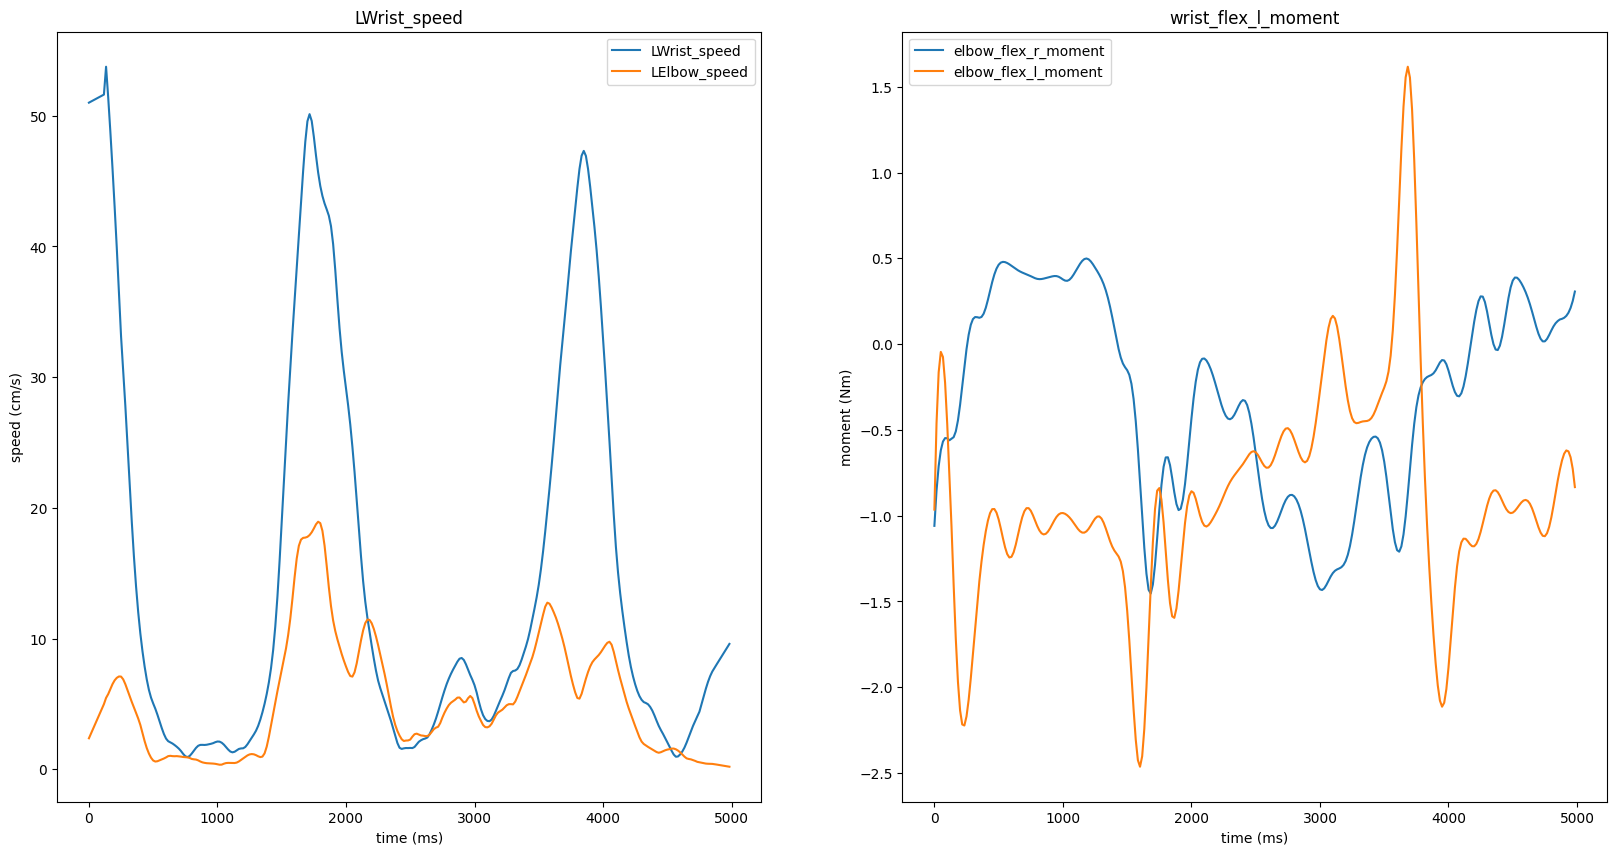

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

# load in one id and mt file with the same trialid
idfiles = glob.glob(MTfolder_processed + '/id*.csv')
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')

id = pd.read_csv(idfiles[0])
print(idfiles[0])
mt = pd.read_csv(mtfiles[0])
print(mtfiles[0])

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(mt['Time'], mt['LWrist_speed'], label='LWrist_speed')
# add LElbow_speed
ax[0].plot(mt['Time'], mt['LElbow_speed'], label='LElbow_speed')
ax[0].set_title('LWrist_speed')
ax[0].set_ylabel('speed (cm/s)')
ax[0].set_xlabel('time (ms)')
ax[0].legend()

# elbow flexion
ax[1].plot(id['time'], id['elbow_flex_r_moment'], label='elbow_flex_r_moment')
ax[1].plot(id['time'], id['elbow_flex_l_moment'], label='elbow_flex_l_moment')
ax[1].set_title('wrist_flex_l_moment')
ax[1].set_ylabel('moment (Nm)')
ax[1].set_xlabel('time (ms)')
ax[1].legend()

plt.show()

## Balance Board


We do XXX

In [ ]:
#| code-fold: true
#| code-summary: Code to process balance board data

BB_files = glob.glob(BBfolder + '*BalanceBoard*.csv', recursive=True)

for bb in BB_files:
    print('working on ' + bb)
    # get trialid
    trialid = bb.split('\\')[-1].split('.')[0]
    # get the first, second, fourth, nineth elements
    trialid = '_'.join(trialid.split('_')[:2] + trialid.split('_')[3:4] + trialid.split('_')[8:9])

    # because we are going to merge on bb, we will store also more information
    fileinfo = bb.split('\\')[-1].split('.')[0]

    # if second element is 1, we will store last three elements
    if fileinfo.split('_')[1] == '1':
        # if there is not 'corrected' in the name, we will store last three elements
        if 'corrected' not in fileinfo:
            info = '_'.join(fileinfo.split('_')[-3:])
        else:
            info = '_'.join(fileinfo.split('_')[-4:])
    elif fileinfo.split('_')[1] == '2':
        # otherwise we store last four elements (5 when corrected)
        if 'corrected' not in fileinfo:
            info = '_'.join(fileinfo.split('_')[-4:])
        else:
            info = '_'.join(fileinfo.split('_')[-5:])

    # Load the balanceboard data
    df_bb = pd.read_csv(bb)

    # Rename columns
    df_bb.columns = ['time_s', 'left_back', 'right_forward', 'right_back', 'left_forward']

    # Calculate sampling rate
    bbsamp = 1 / np.mean(np.diff(df_bb['time_s'] - min(df_bb['time_s'])))

    # Apply Savitzky-Golay filter to smooth the data
    for col in df_bb.columns[1:]:
        df_bb[col] = scipy.signal.savgol_filter(df_bb[col], 51, 5)

    # Calculate COPX and COPY
    COPX = (df_bb['right_forward'] + df_bb['right_back']) - (df_bb['left_forward'] + df_bb['left_back'])
    COPY = (df_bb['right_forward'] + df_bb['left_forward']) - (df_bb['left_back'] + df_bb['right_back'])

    # Calculate COPXc and COPYc
    df_bb['COPXc'] = scipy.signal.savgol_filter(np.insert(np.diff(COPX), 0, 0), 51, 5)
    df_bb['COPYc'] = scipy.signal.savgol_filter(np.insert(np.diff(COPY), 0, 0), 51, 5)

    # Calculate COPc
    df_bb['COPc'] = np.sqrt(df_bb['COPXc']**2 + df_bb['COPYc']**2)

    # restart the time so that starts from 0
    df_bb['time_s'] = df_bb['time_s'] - min(df_bb['time_s'])
    # convert to ms
    df_bb['time_s'] = df_bb['time_s']*1000

    # rename time_s to time
    df_bb.rename(columns={'time_s': 'time'}, inplace=True)

    # Add trialid
    df_bb['TrialID'] = trialid
    # Add info
    df_bb['FileInfo'] = info

    # Write as csv to MTfolder_processed
    df_bb.to_csv(MTfolder_processed + '/bb_' + trialid + '.csv', index=False)

df_bb.head(15)

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\0_2_trial_111_BalanceBoard_stream_nominal_srate500_p1_ziek_geluiden_c0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\0_2_trial_112_BalanceBoard_stream_nominal_srate500_p1_ziek_geluiden_c1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\0_1_pr_0_BalanceBoard_stream_nominal_srate500_p0_bloem_geluiden.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\0_1_trial_3_BalanceBoard_stream_nominal_srate500_p0_vechten_geluiden.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\0_1_trial_4_BalanceBoard_stream_nominal_srate500_p0_ademen_geluiden.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_pr

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo
0,0.000000,1.125796,0.801558,1.557701,1.314984,0.000106,0.000139,0.000175,0_1_8_p0,corrected_corrected_corrected_corrected
1,2.000052,1.125025,0.801057,1.557214,1.314493,0.000165,0.000157,0.000228,0_1_8_p0,corrected_corrected_corrected_corrected
2,4.000105,1.124373,0.800649,1.556812,1.314079,0.000202,0.000164,0.000260,0_1_8_p0,corrected_corrected_corrected_corrected
3,6.000157,1.123830,0.800325,1.556490,1.313736,0.000220,0.000163,0.000274,0_1_8_p0,corrected_corrected_corrected_corrected
4,8.000209,1.123389,0.800075,1.556241,1.313461,0.000225,0.000154,0.000272,0_1_8_p0,corrected_corrected_corrected_corrected
5,10.000262,1.123042,0.799893,1.556060,1.313248,0.000217,0.000139,0.000258,0_1_8_p0,corrected_corrected_corrected_corrected
6,12.000314,1.122782,0.799771,1.555942,1.313093,0.000201,0.000118,0.000234,0_1_8_p0,corrected_corrected_corrected_corrected
7,14.000366,1.122602,0.799703,1.555880,1.312992,0.000179,0.000094,0.000202,0_1_8_p0,corrected_corrected_corrected_corrected
8,16.000418,1.122494,0.799681,1.555870,1.312941,0.000153,0.000067,0.000167,0_1_8_p0,corrected_corrected_corrected_corrected
9,18.000471,1.122453,0.799700,1.555908,1.312934,0.000124,0.000038,0.000130,0_1_8_p0,corrected_corrected_corrected_corrected


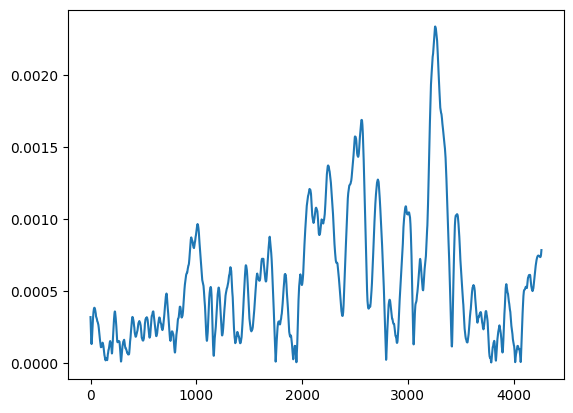

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

bbfiles = glob.glob(MTfolder_processed + '/bb*.csv')
samplebb = pd.read_csv(bbfiles[20])

# plot COPc the sample
plt.plot(samplebb['time'], samplebb['COPc'])
#plt.xlim(1000,2000)
plt.show()